### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

--2024-03-08 20:54:26--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2024-03-08 20:54:26--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc014f6161cd3c89e1b055105a96.dl.dropboxusercontent.com/cd/0/get/COtwx9FzV1uSveaRbdWBlT7mLffAJTWbEpFwDJN5KoiwwyCEsKitd17Sp7IsF3eWzaABjMmf14r-km_rMkdpio_XtglekEDpOTSdNazEe_vF20l6dIb7Qn2CvoY7WCqx5fM/file?dl=1# [following]
--2024-03-08 20:54:26--  https://uc014f6161cd3c89e1b055105a96.dl.dropboxusercontent.com/cd/0/get/COtwx9FzV1uSveaRbdWBlT7mLffAJTWbEpFwDJN5KoiwwyCEsKitd17Sp7IsF3eWzaABjMmf14r-km_rMkdpio_XtglekE

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [3]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

In [4]:
lines[:2]

[' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layers to generate visual and textual attention. The memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question. Our single model outperforms the first place winner on the VQA 1.0 dataset, performs within margin to the current state-\n',
 ' Sequential Short-Text Classification with Recurrent and Convolutional   Neural Networks ; Recent approaches based on artificial neural networks (ANNs) have shown promising results for short-text classification. However, many short texts occur in sequences (e.g., sentences in a document or utterances in a dialog), and most existing ANN-based systems do not leverage the preceding short texts when classifying a subsequent one. In this work, we present a model based on recurre

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [5]:
# get all unique characters from lines (including capital letters and symbols)
tokens = list({x for line in lines for x in line})
tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [6]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {tokens[i]:i for i in range(len(tokens))}

In [7]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`.

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [8]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [9]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
class FixedWindowLanguageModel(nn.Module):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64, strides=1, filter_size=3):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}

        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = nn.Embedding(...)

        #conv parameters
        self.strides = strides
        self.filter_size = filter_size

        self.n_tokens = n_tokens
        self.emb_size = emb_size
        self.hid_size = hid_size

        #embedding layer
        self.embed = nn.Embedding(n_tokens, emb_size)

        #conv layer
        self.conv = nn.Conv1d(in_channels=16, out_channels=hid_size, kernel_size=filter_size, stride=strides, padding=0)

        #some dense layers to map into n_tokens size + additional complexity for our nn
        self.logits = nn.Sequential(nn.Linear(64, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, n_tokens))


    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        # YOUR CODE - apply layers, see docstring above

        #create embeddings
        embeddings = self.embed(input_ix)

        #padding left side (interesting dim=2)

        padded = nn.functional.pad(embeddings, pad=(0, 0, self.strides * (self.filter_size - 1), 0))

        padded_tensor_permuted = torch.permute(padded, (0, 2, 1))

        #conv layer
        conv_tensor = self.conv(padded_tensor_permuted)
        conv_tensor_output = torch.permute(conv_tensor, (0, 2, 1))

        out = self.logits(conv_tensor_output)

        return out # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), device=device, dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [38]:
model = FixedWindowLanguageModel()
print(model)

FixedWindowLanguageModel(
  (embed): Embedding(136, 16)
  (conv): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
  (logits): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=136, bias=True)
  )
)


In [13]:
dummy_model = FixedWindowLanguageModel().to(device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines)).to(device)
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('embed.weight', 'conv.weight', 'conv.bias', 'logits.0.weight', 'logits.0.bias', 'logits.2.weight', 'logits.2.bias')


In [14]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [15]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines])).to(device)
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [16]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix)
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 tensor([[ 1, 66, 67, 68,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 66, 68, 66, 67, 66,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 66, 67, 68, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17,  0]],
       device='cuda:0')
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [17]:
def compute_loss(model, input_ix, device='cuda'):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, device=device, dtype=torch.int64)


    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]
    masked = compute_mask(input_ix)

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.

    #<YOUR CODE>

    #implement softmax along dict dimension
    true_logits = torch.softmax(logits, dim=2)

    #add extra matrix to compute tokens that we only need after
    one_hot = nn.functional.one_hot(reference_answers, num_classes=logits.shape[2])

    #compute final logits
    final_logits = torch.mul(true_logits, one_hot)
    sum_rows = torch.sum(final_logits, dim=2)

    #take log
    logged = torch.log(torch.masked_select(sum_rows, masked[:, 1:]))

    #compute loss
    loss = - torch.sum(logged)

    #<END OF CODE>

    #return <YOUR CODE: return scalar loss>

    return loss/input_ix.shape[0]



In [18]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
print(loss_1, loss_2)
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

tensor(43.3288, device='cuda:0', grad_fn=<DivBackward0>) tensor(43.3288, device='cuda:0', grad_fn=<DivBackward0>)


### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [19]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [20]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 128
score_dev_every = 150
train_history, dev_history = [], []
model = FixedWindowLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

#256 batch size
#score every 250
#epochs 5000

Sample before training: BridgingHá 4Mσőe0ürαωÖA*AqzçÉà'0εRhäcâZ:J^ΠHlhu8m<n9K3ïêR{a]V(ε(SÜêAYαÉ~RσA*=++>IF`°ï?ρ4ωhI/zö+$F`+śh


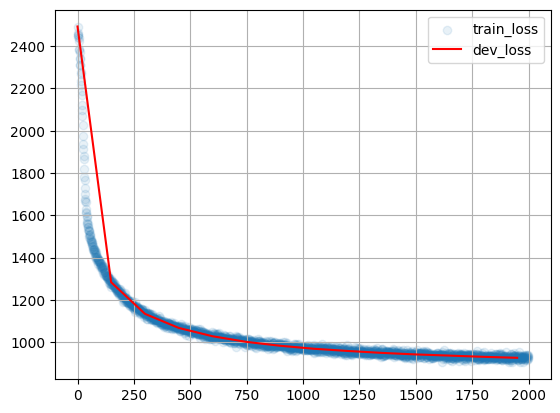

Generated examples (tau=0.5):
 Nous are detes a minal for propose the is partial with or strated on the spactions in spary a the pr
 The sumple propose and the strate that ter a propose the provely probut to in algorith the sumpresen


100%|██████████| 2000/2000 [01:02<00:00, 31.75it/s]

 Conal for the problem opprov such dee to the dification the compres and the rellir ence as and and h


In [21]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 2000):
    batch = to_matrix(sample(train_lines, batch_size))


    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [22]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 926.8035294636052
 A beed to rection a Subjection imation are in and to comples of a timenting rese frame such evally c
 many and to and the such the stack is proving the convolutions the in the comples in the same are th
 A the the proces from to gent deterve a sime the sumber the such as comples of the proving strading 
 Distated the to a siment the lassive the to in to a pred that can a proble inters of the of the in s
 spection of Superance comple the exts varive proach recent mach as formations a may and the a prover
 That cons of the colrencess and and the sure the Suction of the deteration sure aral grains are prop
 An mance a section to shaper. The problem on in proach as the the sequer with data a network and str
 Convidel cons in learning straintic simic and a proble in the somparame such and moder by exteries t
 A Nonomation of station the proach a notic and mility the prove an in the stance for the ext a funin
 mation the such a rith in modeling the problem 

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [43]:
class RNNLanguageModel(nn.Module):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        # YOUR CODE - create layers/variables/etc

        self.embedding = nn.Embedding(n_tokens, emb_size)

        self.lstm = nn.LSTM(emb_size, hid_size, batch_first=True)

        self.dense = nn.Linear(hid_size, n_tokens)

        #END OF YOUR CODE

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers, see docstring above

        #embedding layer
        embeddings = self.embedding(input_ix)

        #lstm layer
        output, (h_n, c_n) = self.lstm(embeddings)

        #dense layer
        logits = self.dense(output)

        return logits # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), device=device, dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))

In [44]:
model = RNNLanguageModel()
print(model)

RNNLanguageModel(
  (embedding): Embedding(136, 16)
  (lstm): LSTM(16, 256, batch_first=True)
  (dense): Linear(in_features=256, out_features=136, bias=True)
)


In [45]:
model = RNNLanguageModel().to(device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines)).to(device)
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('embedding.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'dense.weight', 'dense.bias')


In [46]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines])).to(device)
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [47]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 150
train_history, dev_history = [], []

model = RNNLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingçμ s:U0ρõ?TDρ2ãsç/qq



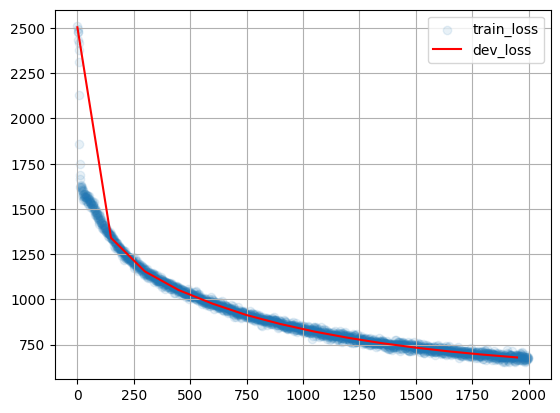

Generated examples (tau=0.5):
 Recognition of However Sach Transfer Convolutional Network ; A recognition of a sensitions and super


100%|██████████| 2000/2000 [02:28<00:00, 13.46it/s]

 A Weaghmatic notion Pattic Neural Networks with Semantic Spaces ; A composition of the network of si
 Conceptions of Consistency Model Networks for Boosed Problems ; One more the considering as a constr


In [48]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 2000):
    batch = to_matrix(sample(train_lines, batch_size))

    #<YOUR CODE - one step of the training loop for your RNN model>

    loss_i = compute_loss(model, batch)
    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [49]:
#48 min

In [50]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 679.3813133693789
 Somples to an and to exployer feature convents of the specifical sets ; We propose the similarity to
 A Searning of Algorithms for Instraint Algorithm for Convolutional Neural Network ; We present a set
 Compression of Addoch Exploit The Sacced Some Complexing ; We propose a novel and the learning of pe
 Learning ; A many comparally in models for networks of networks for the expering the computing the c
 Explore of Data for Matrix Learning ; We present a general sets the models of the proposed to a simp
 A More System From Convolutional Neural Networks ; The consider to the problem of a provide the more
 Toward Application ; In the field for supervised and multi-deep networks and converting the neural n
 A Bayesian Network From Tasks ; We provide to a single consisting sensity and the object computation
 A Model Detection ; This paper propose the study the good uninguration to subsed of not methods in t
 In this can be interventily in a vision such th

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize:
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if it is any good.

In [51]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix

    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus

    """
    while True:

        token_probs = model.get_possible_next_tokens(prefix)

        #sort to find  n tokens according to dynamic sampling
        token_probs_sorted = sorted(token_probs.items(), key=lambda x: x[1], reverse=True)

        #nucleus sampling
        total_prob, counter = 0, 0
        for token in token_probs_sorted:
            if total_prob <= nucleus:
                counter += 1
                total_prob += token[1]

        tokens, probs = zip(*token_probs_sorted[:17])

        sum = np.sum(probs)
        normalized_probs = np.array(probs)/sum

        next_token = np.random.choice(tokens, p=normalized_probs)

        prefix += next_token

        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [52]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.7))

 By training implate-images, contresent a langues the longl calsur and that tatcing plocesslu to coma
 Interaction Probability" signifing and sucter there are reconstruction. We introduced popular, the i
 Senging Multise Search A Tass-Sode Programmin Interrbal Rolo Model Scale ; Adven the strectional for
 Deside Model: Rank-Collective Even And Lynained Bayes ; Hwopheses facl system for the use context pi
 Gacipling and Images are Paralistic Sasces ; We correstuled f\embrsed on text fan to the idenamic vi
 Mettodogy Features fo Calible Instence, Secial Analyzy-Data method ; We fourm engarametric from nots
 On-Noussitient Tranenty-Retrainidgor to Enstrative Best Emotion (MPRP) with discriptor maximization 
 Multiple Shallty of First-Peegred Comparisul in Neural Crossiful Imploming Computive Algorithm for c
 Reduct Teight Stable Anderat Robuss ; Surractured that the sequent stase alsondaty of intereon a res
 Approitional Compition Specialy Cascer's (TTCC) with as well has relain relations

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it.

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [53]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [54]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus
    """

    #initial beams

    token_probs = model.get_possible_next_tokens(prefix)
    token_probs_sorted = sorted(token_probs.items(), key=lambda x: x[1], reverse=True)
    beams = {prefix + token[0]: token[1] for token in token_probs_sorted[:beam_size]}
    length_counter = 0

    while length_counter < length-1:  #we do not include prefix

        additional_beams = {}

        for prefix in beams:
            token_probs = model.get_possible_next_tokens(prefix)
            token_probs_sorted = sorted(token_probs.items(), key=lambda x: x[1], reverse=True)

            for token_prob in token_probs_sorted[:beam_size]:
                additional_beams[prefix + token_prob[0]] = beams[prefix] * token_prob[1]

        #update additional beams:
        sorted_additional_beams = sorted(additional_beams.items(), key=lambda x: x[1], reverse=True)
        beams = {token[0]:token[1] for token in sorted_additional_beams[:beam_size]}
        length_counter += 1

    beams_sorted = sorted(beams.items(), key=lambda x: x[1], reverse=True)

    return beams_sorted[0][0]


In [55]:
generate_beamsearch(model, prefix='Transfer ', beam_size=5, length=150)

'Transfer the problem of the problem of this paper, we propose the problem of the problem of the problem of the problem of the problem of the problem of the pro'